# Lasagne Conv Net on Media Eval 2015 Placing Task - Locale

In [43]:
# Import Python libraries
import numpy as np
import theano
import theano.tensor as Tensor
import lasagne
import time

# allows plots to show inline in ipython notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# Import own modules
import data_utils, visualize
import lasagne_model_predict_country as cnn_model

In [ ]:
# Model hyperparameters
num_filters = 32
filter_width = 5
pool_width = 2
hidden_size = 256 # size of hidden layer of neurons
dropout_p = 0.0
# lr_decay = 0.995
reg_strength = 0
# grad_clip = 10

# Optimization hyperparams
LEARNING_RATE = 1e-2
MOMENTUM = 0.9
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'

# Training parameters
batchsize = 500
num_epochs = 8
record_per_iter = True  # save train and val loss/accuracy after each batch runthrough

In [49]:
# Load Data Set

# DATA_BATCH = '000_small_'
# DATA_SIZE = '48by32'
# DATA_SET = DATA_BATCH + DATA_SIZE
# NUM_CLASSES = 5

DATA_SET = 'subset_48by32_5'
NUM_CLASSES = 5
NUM_BATCHES = 6

print ('Data Set:', DATA_SET)
print ('Num classes:', NUM_CLASSES)
print ('Preparing Data Set....')

X_input_filename = 'data_maps/' + DATA_SET + '/x_input_0.npy'
Y_output_filename = 'data_maps/' + DATA_SET + '/y_labels_0.npy'

X = data_utils.load_npy_file(X_input_filename)
Y = data_utils.load_npy_file(Y_output_filename)
# print 'X: {}'.format(X.shape)
# print 'Y: {}'.format(Y.shape)
# print 'Y sample ', Y[:10]

num_samples, H, W, C = X.shape

# swap C and H axes --> expected input
X = np.swapaxes(X, 1, 3)  # (num_samples, C, W, H)
X -= np.mean(X, axis = 0)  # Data Preprocessing: mean subtraction

#Splitting into train, val, test sets

num_train = int(num_samples * 0.8)
num_val = int(num_samples * 0.1)
num_test = num_samples - num_train - num_val

# print 'num_train: %d, num_val: %d, num_test: %d' % (num_train, num_val, num_test)

X_train = X[:num_train]
X_val = X[num_train:num_train+num_val]
X_test = X[num_train+num_val:]

y_train = Y[:num_train]
y_val = Y[num_train:num_train+num_val]
y_test = Y[num_train+num_val:]

print ('X_train', X_train.shape)
print ('y_train', y_train.shape)
print ('X_val', X_val.shape)
print ('y_val', y_val.shape)
print ('X_test', X_test.shape)
print ('y_test', y_test.shape)


Data Set: subset_48by32_5
Num classes: 5
Preparing Data Set....
X_train (24000, 3, 48, 32)
y_train (24000,)
X_val (3000, 3, 48, 32)
y_val (3000,)
X_test (3000, 3, 48, 32)
y_test (3000,)


In [50]:
# Prepare Theano variables for inputs and targets
input_var = Tensor.tensor4('inputs')
target_var = Tensor.ivector('targets')

print('Building network...')

# Create neural network model
l_in, l_out = cnn_model.build_cnn(C, W, H, NUM_CLASSES, num_filters=num_filters, filter_width=filter_width, pool_width=pool_width, hidden_size=hidden_size, dropout=dropout_p, inputVar = input_var)

print('Compiling functions...')

# Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
prediction = lasagne.layers.get_output(l_out)
loss = Tensor.nnet.categorical_crossentropy(prediction, target_var)
# loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()
acc = Tensor.mean(Tensor.eq(Tensor.argmax(prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

# Return predictions in a function
pred_fn = theano.function([l_in.input_var], prediction)

 # Create update expressions for training, i.e., how to modify the
# parameters at each training step. Here, we'll use Stochastic Gradient
# Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
params = lasagne.layers.get_all_params(l_out, trainable=True)
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=LEARNING_RATE, momentum=MOMENTUM)


# Create a loss expression for validation/testing. The crucial difference
# here is that we do a deterministic forward pass through the network,
# disabling dropout layers.
test_prediction = lasagne.layers.get_output(l_out, deterministic=True)
# test_loss = lasagne.objectives.categorical_crossentropy(test_prediction, target_var)
test_loss = Tensor.nnet.categorical_crossentropy(test_prediction, target_var)

test_loss = test_loss.mean()
# As a bonus, also create an expression for the classification accuracy:
test_acc = Tensor.mean(Tensor.eq(Tensor.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

 # Compile a function performing a training step on a mini-batch (by giving
# the updates dictionary) and returning the corresponding training loss:
train_fn = theano.function([input_var, target_var], [loss, acc], updates=updates)
# train_fn = theano.function([input_var, target_var], loss, updates=updates)

# Compile a second function computing the validation loss and accuracy:
val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

print('Compiling Finished!')

Building network...
Compiling functions...
Compiling Finished!


In [57]:
# Finally, launch the training loop.
print ('Training on:', num_epochs, 'epochs of batch size', batchsize)
print("Starting training...")
# We iterate over epochs:
train_err_list = []
val_err_list = []
train_acc_list = []
val_acc_list = []
for epoch in range(num_epochs):
    # 1) In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    
    # Each batch is 1 iteration
    num_iters = 0
    for batch in data_utils.iterate_minibatches(X_train, y_train, batchsize, shuffle=True):
        # For testing, limit num iterations
#         if num_iters >= 2:
#             break
        inputs, targets = batch
        iter_train_err, iter_train_acc = train_fn(inputs, targets)
#         prediction = pred_fn(inputs)
        train_err += iter_train_err
        train_acc += iter_train_acc
        train_batches += 1
        
        # Run validation on entire data set after each iteration, not iterating over mini batches of 
        
        val_err, val_acc = val_fn(inputs, targets)
        
        if record_per_iter:
            train_err_list.append(iter_train_err)
            train_acc_list.append(iter_train_acc)
            val_err_list.append(val_err)
            val_acc_list.append(val_acc)
        
        print("Ep {} \titer {}  \tloss {:.5f}, train acc {:.2f}, val acc {:.2f}".format(epoch, num_iters, float(iter_train_err), iter_train_acc * 100, val_acc *100 ))
        num_iters += 1

    # Then we print the results for this epoch:
    
    epoch_train_err = train_err / train_batches
    epoch_train_acc = train_acc / train_batches * 100
    epoch_val_err = val_err / 1
    epoch_val_acc = val_acc / 1 * 100
    
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(epoch_train_err))
    print("  training accuracy:\t\t{:.2f} %".format(epoch_train_acc))
    print("  validation loss:\t\t{:.6f}".format(epoch_val_err))
    print("  validation accuracy:\t\t{:.2f} %".format(epoch_val_acc))
    
#     if not record_per_iter:
    epochs_train_err_list.append(epoch_train_err)
    epochs_train_acc_list.append(epoch_train_acc)
    epochs_val_err_list.append(epoch_val_err)
    epochs_val_acc_list.append(epoch_val_acc)

print('Training finished!')

Starting training...
Training on: 8 epochs of batch size 500
Ep 0 	iter 0  	loss 1.60695, train acc 20.00, val acc 20.00
Ep 0 	iter 1  	loss 1.60591, train acc 21.20, val acc 21.20
Ep 0 	iter 2  	loss 1.60751, train acc 16.40, val acc 16.40
Ep 0 	iter 3  	loss 1.60665, train acc 20.20, val acc 24.00
Ep 0 	iter 4  	loss 1.60231, train acc 26.00, val acc 26.00
Ep 0 	iter 5  	loss 1.60425, train acc 25.00, val acc 25.00
Ep 0 	iter 6  	loss 1.60616, train acc 22.60, val acc 22.60
Ep 0 	iter 7  	loss 1.60596, train acc 25.40, val acc 25.40
Ep 0 	iter 8  	loss 1.60478, train acc 24.40, val acc 24.40
Ep 0 	iter 9  	loss 1.60322, train acc 24.00, val acc 24.00
Ep 0 	iter 10  	loss 1.60297, train acc 25.60, val acc 25.60
Ep 0 	iter 11  	loss 1.60281, train acc 24.80, val acc 24.80
Ep 0 	iter 12  	loss 1.60068, train acc 25.40, val acc 25.40
Ep 0 	iter 13  	loss 1.60170, train acc 26.80, val acc 26.80
Ep 0 	iter 14  	loss 1.60606, train acc 22.80, val acc 22.80
Ep 0 	iter 15  	loss 1.60064, trai

In [59]:
# After training, we compute and print the test error:
print('Testing...')
test_err = 0
test_acc = 0
test_batches = 0
for batch in data_utils.iterate_minibatches(X_test, y_test, batchsize, shuffle=False):
    inputs, targets = batch
    err, acc = val_fn(inputs, targets)
    test_err += err
    test_acc += acc
    test_batches += 1
    
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

Testing...
Final results:
  test loss:			1.601790
  test accuracy:		23.40 %


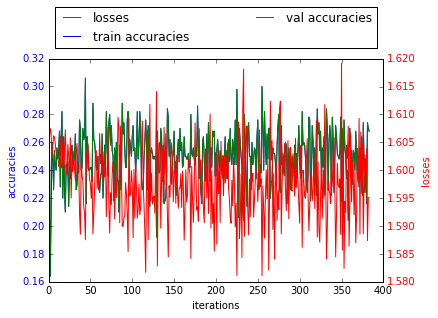

In [60]:
# Visualize the loss and the accuracies for both training and validation sets for each epoch
num_train = X_train.shape[0]
if record_per_iter:
    xlabel = "iterations"
else:
    xlabel = "epochs"
# Printing training losses and training + validation accuracies
visualize.plot_loss_acc('subset_5_train', train_err_list, train_acc_list, val_acc_list, LEARNING_RATE, reg_strength, num_epochs, num_train, xlabel=xlabel)

In [62]:
# Visualize the loss and the accuracies for both training and validation sets for each epoch
num_train = X_train.shape[0]
xlabel = "epochs"
# Printing training losses and training + validation accuracies
visualize.plot_loss_acc('subset_5_train_epochs', epochs_train_err_list, epochs_train_acc_list, epochs_val_acc_list, LEARNING_RATE, reg_strength, num_epochs, num_train, xlabel=xlabel)


NameError: name 'epoch_train_err_list' is not defined